In [81]:
import numpy as np
import pandas as pd
import math

import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import concatenate
import tifffile

from sklearn.model_selection import train_test_split

import os

import scipy

In [10]:
tiles = pd.read_csv(r'.\Data\Tiles_expanded.csv')

In [11]:
tiles.head(5)

,Tile_ID,Long2,Lat2,Long1,Lat1,Mid_lat,Mid_long,Stop_Signs,Paving_historical,Paving_future,Bus_stop,Collisions_Future,Collisions_Historical
0,36,-122.514446,37.779636,-122.513306,37.778732,37.779184,-122.513876,0.0,0.0,0.0,0.0,0.0,0.0
1,37,-122.514446,37.778732,-122.513306,37.777829,37.778280,-122.513876,0.0,0.0,0.0,0.0,0.0,0.0
2,151,-122.513306,37.779636,-122.512166,37.778732,37.779184,-122.512736,0.0,0.0,0.0,0.0,0.0,0.0
3,152,-122.513306,37.778732,-122.512166,37.777829,37.778280,-122.512736,0.0,0.0,0.0,0.0,0.0,0.0
4,153,-122.513306,37.777829,-122.512166,37.776925,37.777377,-122.512736,0.0,0.0,0.0,0.0,0.0,0.0


Split into training and test

In [12]:
x_train, x_test, y_train, y_test = train_test_split(tiles[['Tile_ID','Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop']], 
                                   tiles['Collisions_Future'],
                                   random_state=104, 
                                   test_size=0.20, 
                                   shuffle=True)

Model #1: Linear regression using Historical Collisions, SFMTA Street Characteristics, and Geocoordinates

In [13]:
# x: 'Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop'
# y: 'Collisions_Future'

def create_linear_model():

    input = tf.keras.layers.Input(shape=(6,))
    
    #input_t = tf.data.Dataset.from_tensor_slices(input.to_dict(orient="list"))

   # normalized = layers.Normalization(input_shape=[5,], axis=None)(input)

   #x = normalizer(input_t)

    outputs = layers.Dense(1)(input)

    linear_model = tf.keras.models.Model(inputs=input, outputs=outputs, name="linear_model")

    linear_model.summary()

    linear_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_absolute_error' #,
        #metrics = [tf.keras.metrics.Accuracy()]
        )
    
    return linear_model

linear_model = create_linear_model()

history = linear_model.fit(
    np.asarray(x_train[['Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop']]).astype('float32'),
    y_train,
    epochs=20,
    # Suppress logging.
     verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Model: "linear_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 6)]               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
210/210 [==============================] - 2s 4ms/step - loss: 99.0211 - val_loss: 81.7797
Epoch 2/20
210/210 [==============================] - 1s 3ms/step - loss: 64.7638 - val_loss: 47.5534
Epoch 3/20
210/210 [==============================] - 0s 2ms/step - loss: 30.5083 - val_loss: 13.3272
Epoch 4/20
210/210 [==============================] - 1s 3ms/step - loss: 3.8097 - val_loss: 1.4877
Epoch 5/20
210/210 [==============================

In [14]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
   # plt.plot(history.history['accuracy'], label='accuracy')
   # plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True)

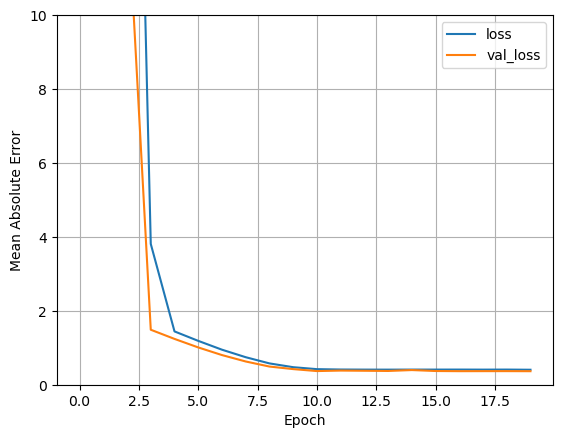

In [15]:
plot_loss(history)

**Model #2: Neural Network Using Satellite Images, Historical Collisions, SFMTA Street Characteristics, and Geocoordinates**

Image Pre-Processing

In [16]:
IMAGE_PATH = './Satellite Imagery/Satellite Images Tiled/' 

In [18]:
#eda
img = tifffile.imread('./Satellite Imagery/Satellite Images Tiled/36.tif')[0:148, 0:188, :]
img2 = tifffile.imread('./Satellite Imagery/Satellite Images Tiled/37.tif')[0:148, 0:188, :]

In [19]:
# eda
print(np.shape(img2))

(149, 188, 4)


In [30]:
# eda
test = []
test.append(img[0:148, 0:188, :])
test.append(img2[0:148, 0:188, :])
print(np.shape(test))
test = np.stack(test)
print(np.shape(test))

(2, 148, 188, 4)
(2, 148, 188, 4)


In [33]:
def preprocess_data_part1(IMAGE_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 149 3)
    """
    
    data_mini = []
    
    for id in x_train['Tile_ID']:    
                    
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]
            
        # append to images
        data_mini.append(image)
 
    # stack images and trasnform to array
    images_mini = np.stack(data_mini)
    
    return images_mini

In [74]:
# THERE IS ONE FILE IN THE "SATELLITE IMAGES TILED" FOLDER THAT IS NOT A TIF IMAGE, DELETE THIS FILE
images_mini = preprocess_data_part1(IMAGE_PATH)

In [39]:
np.shape(images_mini)

(8376, 148, 188, 4)

Street Data Pre-Processing

In [78]:
street = np.asarray(x_train[['Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop']]).astype('float32')
street_mini = []
for row in t:
    street_mini.append([[row]])
street_mini = np.stack(street_mini)
np.shape(street_mini)

(8376, 1, 1, 6)

Modeling <br> 

Helpful Links: <br>
https://pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/ <br>
https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50 <br>
https://github.com/jimmyyhwu/resnet18-tf2/blob/master/resnet.py <BR>

In [73]:
# RESNET 18 TAKEN FROM https://github.com/jimmyyhwu/resnet18-tf2/blob/master/resnet.py
# HELPS RUN MODEL BELOW

kaiming_normal = keras.initializers.VarianceScaling(scale=2.0, mode='fan_out', distribution='untruncated_normal')

def conv3x3(x, out_planes, stride=1, name=None):
    x = layers.ZeroPadding2D(padding=1, name=f'{name}_pad')(x)
    return layers.Conv2D(filters=out_planes, kernel_size=3, strides=stride, use_bias=False, kernel_initializer=kaiming_normal, name=name)(x)

def basic_block(x, planes, stride=1, downsample=None, name=None):
    identity = x

    out = conv3x3(x, planes, stride=stride, name=f'{name}.conv1')
    out = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.bn1')(out)
    out = layers.ReLU(name=f'{name}.relu1')(out)

    out = conv3x3(out, planes, name=f'{name}.conv2')
    out = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.bn2')(out)

    if downsample is not None:
        for layer in downsample:
            identity = layer(identity)

    out = layers.Add(name=f'{name}.add')([identity, out])
    out = layers.ReLU(name=f'{name}.relu2')(out)

    return out

def make_layer(x, planes, blocks, stride=1, name=None):
    downsample = None
    inplanes = x.shape[3]
    if stride != 1 or inplanes != planes:
        downsample = [
            layers.Conv2D(filters=planes, kernel_size=1, strides=stride, use_bias=False, kernel_initializer=kaiming_normal, name=f'{name}.0.downsample.0'),
            layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.0.downsample.1'),
        ]

    x = basic_block(x, planes, stride, downsample, name=f'{name}.0')
    for i in range(1, blocks):
        x = basic_block(x, planes, name=f'{name}.{i}')

    return x

def resnet(x, blocks_per_layer, num_classes=1000):
    x = layers.ZeroPadding2D(padding=3, name='conv1_pad')(x)
    x = layers.Conv2D(filters=64, kernel_size=7, strides=2, use_bias=False, kernel_initializer=kaiming_normal, name='conv1')(x)
    x = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name='bn1')(x)
    x = layers.ReLU(name='relu1')(x)
    x = layers.ZeroPadding2D(padding=1, name='maxpool_pad')(x)
    x = layers.MaxPool2D(pool_size=3, strides=2, name='maxpool')(x)

    x = make_layer(x, 64, blocks_per_layer[0], name='layer1')
    x = make_layer(x, 128, blocks_per_layer[1], stride=2, name='layer2')
    x = make_layer(x, 256, blocks_per_layer[2], stride=2, name='layer3')
    x = make_layer(x, 512, blocks_per_layer[3], stride=2, name='layer4')

    x = layers.GlobalAveragePooling2D(name='avgpool')(x)
    initializer = keras.initializers.RandomUniform(-1.0 / math.sqrt(512), 1.0 / math.sqrt(512))
    x = layers.Dense(units=num_classes, kernel_initializer=initializer, bias_initializer=initializer, name='fc')(x)

    return x

def resnet18(x, **kwargs):
    return resnet(x, [2, 2, 2, 2], **kwargs)

def resnet34(x, **kwargs):
    return resnet(x, [3, 4, 6, 3], **kwargs)

In [80]:
# x: Satellite Images, 'Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop'
# y: 'Collisions_Future'

# ACCORDING TO THE PAPER, THEY DOWNSIZED THE IMAGES FIRST INTO SMALLER MATRICES 
# THEN ADDED THE STREET CHARACTERISTICS TO THE SMALLER MATRIX
# REFERENCE THE DIAGRAM ON THE PAPER

def create_cnn_model():

    # INPUT LAYERS
    input1 = tf.keras.layers.Input(shape=(148, 188, 4), name='Input_Images')
    input2 = tf.keras.layers.Input(shape=(1,1,6), name='Input_Street')
    
    #CNN FOR IMAGE PROCESSING
    cnn = tf.keras.layers.Conv2D(6, (3,3), activation="relu")(input1)
    pooling = tf.keras.layers.MaxPooling2D((4, 4), strides=2)(cnn)
    images = tf.keras.models.Model(inputs=input1, outputs=pooling)
    
    #ADDING STREET DATA
    #combined = concatenate([images.output, input2])
    combined = tf.keras.layers.Add()([images.output, input2])
    
    # PAPER USES RESNET-18 FOR THE REST OF THE MODEL WITH THE COMBINED DATA
    resnet = resnet18(combined)
    output = tf.keras.layers.Dense(units=1, activation=None, name='output')(resnet)
    
    #instantiation layer 
    cnn_model = tf.keras.models.Model(inputs=[input1, input2], outputs=output)
    
    return cnn_model

cnn_model.summary()

cnn_model = create_cnn_model()

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_absolute_error' #,
    #metrics = [tf.keras.metrics.Accuracy()]
    )

history = cnn_model.fit(
    [images_mini, street_mini],
    np.stack(y_train),
    epochs=5,
    # Suppress logging.
     verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Images (InputLayer)      [(None, 148, 188, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_16 (Conv2D)             (None, 146, 186, 6)  222         ['Input_Images[0][0]']           
                                                                                                  
 max_pooling2d_16 (MaxPooling2D  (None, 72, 92, 6)   0           ['conv2d_16[0][0]']              
 )                                                                                                
                                                                                           

                                                                                                  
 layer2.0.conv2_pad (ZeroPaddin  (None, 11, 14, 128)  0          ['layer2.0.relu1[0][0]']         
 g2D)                                                                                             
                                                                                                  
 layer2.0.downsample.0 (Conv2D)  (None, 9, 12, 128)  8192        ['layer1.1.relu2[0][0]']         
                                                                                                  
 layer2.0.conv2 (Conv2D)        (None, 9, 12, 128)   147456      ['layer2.0.conv2_pad[0][0]']     
                                                                                                  
 layer2.0.downsample.1 (BatchNo  (None, 9, 12, 128)  512         ['layer2.0.downsample.0[0][0]']  
 rmalization)                                                                                     
          

 layer3.1.conv2 (Conv2D)        (None, 5, 6, 256)    589824      ['layer3.1.conv2_pad[0][0]']     
                                                                                                  
 layer3.1.bn2 (BatchNormalizati  (None, 5, 6, 256)   1024        ['layer3.1.conv2[0][0]']         
 on)                                                                                              
                                                                                                  
 layer3.1.add (Add)             (None, 5, 6, 256)    0           ['layer3.0.relu2[0][0]',         
                                                                  'layer3.1.bn2[0][0]']           
                                                                                                  
 layer3.1.relu2 (ReLU)          (None, 5, 6, 256)    0           ['layer3.1.add[0][0]']           
                                                                                                  
 layer4.0.

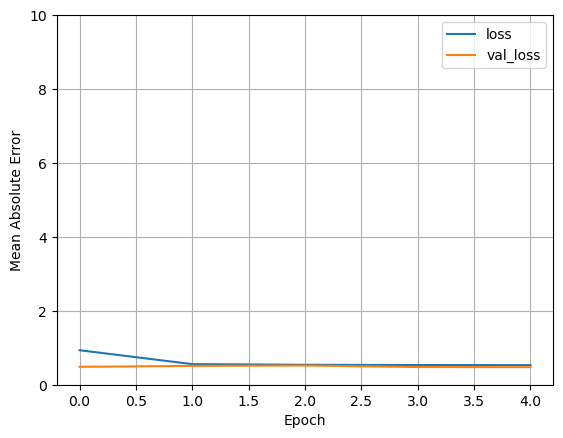

In [82]:
plot_loss(history)